In [ ]:
# Useful for debugging
%load_ext autoreload
%autoreload 2

# Simple GPT example
----
This example shows the basic usage of the LUME-GPT class object used to drive GPT simulations from Python.  Typically, the first step in using a GPT object is setting up a template directory.  This directory should include the GPT input file (typically 'gpt.in') and a folder (typically named 'fields') where any field maps shoule be stored.  Here the template directory is 'lume-gpt/templates/dcgun'.  This example includes an GPT file with a dcgun followed by a solenoid, both modeled by field maps.  A static input particle GDF files is also included.  Later, creating a distribution on the fly is discussed.

In [2]:
import sys, os
root = os.path.join(os.getcwd(), '../')

sys.path.append(root)

INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')

from gpt import GPT

Initialization  of the GPT object requires provided the input_file, among other possible inputs.

In [3]:
G = GPT(input_file=INPUT_FILE, verbose=True)

GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpr_z2okj8"


The GPT object is configured to run on configuration.  Unless specified, the simulatin is configured to run in a temporay directory, as can be seen above.  At this point the GPT file in template directory has been read in and variables lines of the form "name = value;" have been loaded into G.input['variables']:

In [4]:
G.input['variables']

{'data_dump': 0.0,
 'Master_RF': 1300000000.0,
 'MTE': 120.0,
 'gun_voltage': 300.0,
 'sol_1_current': 3.32107,
 'auto_phase': 0.0,
 'single_particle': 0.0,
 'space_charge': 1.0,
 'space_charge_type': 1.0,
 'viewscreens_on': 1.0,
 'kill_backwards_particles': 1.0,
 'optimize_on': 0.0,
 'xoffset': 0.0,
 'yoffset': 0.0,
 'RadiusMax': 0.04,
 'GBacc': 5.5,
 'xacc': 6.5,
 'dtmin': 1e-16,
 'dtmax': 1e-10,
 'ZSLA01': 0.344,
 'ZCTB01': 0.746,
 'ZSLA02': 1.16,
 'Zdcgun': 0.15,
 'Maxdcgun': 500.0,
 'SLAPolarity': -1.0,
 'LSLA01': 0.6,
 'XSLA01': 0.0,
 'YSLA01': 0.0,
 'THXSLA01': 0.0,
 'IA1SDR01_z': 0.922,
 'ZSTOP': 1.5,
 'Alpha': 1.0,
 'Fn': 0.5,
 'verror': 0.005,
 'Nstd': 5.0,
 'tree_code_theta': 1.0,
 'tree_code_R': 1e-06,
 'Ntout': 50.0,
 'tmax': 1e-08,
 'ZSTART': -0.005}

These represent all variables in the input file that can have value replacements substituted into the final gpt file used to run the simulation.  Replacements are handled by passing in a dictionary of names and values to GPT.set_variables(settings).  The function returns a dictionary of names and booleans if the variable replace was successful (a False value typically indicates the variables was not found in the input file):  

In [5]:
variables_were_set = G.set_variables({'gun_voltage':375,'sol_1_current':-3})
print(variables_were_set)

{'gun_voltage': True, 'sol_1_current': True}


To run the GPT simulation, with the above variable replacements made, simply call GPT.run():

In [6]:
G.run()

GPT.run_gpt:
   Running GPT in "/private/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpr_z2okj8"
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpr_z2okj8/gpt.in"

General Particle Tracer - Oct 28 2014


This causes the GPT to run and the output data loaded into the GPT object.  Important data is stored in the GPT.output dictionary.  The raw screen and tout data is stored in G.screen and G.tout respectively.  The general info of the object and run can be printed using print(GPT):

In [7]:
print(G.output.keys())
print('number of screens:',len(G.screen))
print('number of touts:', len(G.tout))

# Info
print(G)

dict_keys(['particles', 'start_time', 'run_time', 'run_error'])
number of screens: 1
number of touts: 32

GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpr_z2okj8
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.4959099292755127 (sec)


In [8]:
# Unique fingerprint based on input
G.fingerprint()

'f7cd80d35b1b455dd8fa33daeb12128e'

# Particle stats
The tout data is automatically loaded into PMD Beam Physics ParticleGroup format.  Statistical quantities based on that data are computed and stored in GPT.stat:

In [9]:
# Some statistic that can be calculated on the particles
G.stat('norm_emit_x')

array([1.74030520e-06, 5.05909040e-06, 9.42959863e-06, 4.14775510e-06,
       4.45535914e-06, 4.78537885e-06, 6.04877282e-06, 1.37250961e-05,
       2.36687039e-05, 1.35630072e-05, 6.72500649e-06, 5.54286370e-06,
       5.33795109e-06, 5.28033365e-06, 5.26623428e-06, 5.28496931e-06,
       5.31665694e-06, 5.35511987e-06, 5.39594978e-06, 5.43613618e-06,
       5.47522119e-06, 5.51203764e-06, 5.54623121e-06, 5.57758645e-06,
       5.60675337e-06, 5.63374633e-06, 5.65841850e-06, 5.68083101e-06,
       5.70121776e-06, 5.71991618e-06, 5.73705441e-06, 5.75273071e-06])

In [10]:
# The units
G.stat_units('norm_emit_x')

pmd_unit('m', 1, (1, 0, 0, 0, 0, 0, 0))

# Plot Statistics
Plotting basic statistical data is then simple, simply requred the desired data from G.stat:

In [11]:
from matplotlib import pyplot as plt
import matplotlib 

%matplotlib inline
%config InlineBackend.figure_format = 'retina'


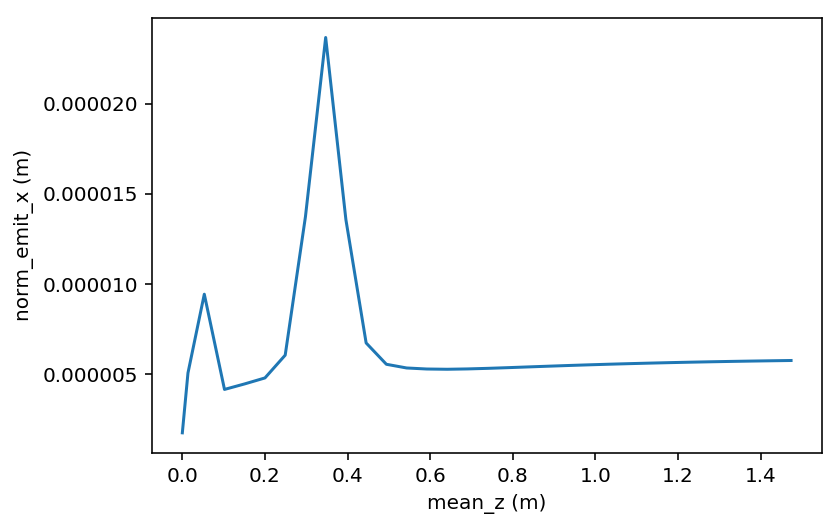

In [12]:
key1 = 'mean_z'
key2 = 'norm_emit_x'
dat1 = G.stat(key1)
dat2 = G.stat(key2)
units1 = G.stat_units(key1)
units2 = G.stat_units(key2)

fig, ax = plt.subplots()
ax.plot(dat1, dat2);
ax.set_xlabel(key1+f' ({units1})');
ax.set_ylabel(key2+f' ({units2})');

# Particle Densities
PMD Beam Physics has some nice built in features for plotting particle distributions.  Below is a 2d histogram with marginal plots of the last tout:

In [13]:
from pmd_beamphysics.plot import marginal_plot

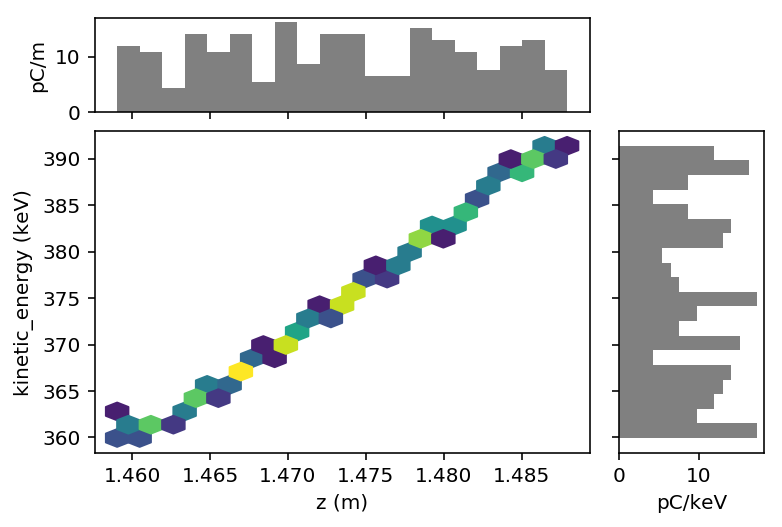

In [14]:
P = G.output['particles'][-1]

marginal_plot(P, 'z', 'kinetic_energy', bins=20)

In [15]:
# Running using the run_gpt: the actions above are combined into one user function
from gpt.gpt import run_gpt

In [16]:
G = run_gpt(settings={'gun_voltage':375,'sol_1_current':-3},
            gpt_input_file=INPUT_FILE)

In [17]:
print(G)


GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpgjs1th7m
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.4067060947418213 (sec)


# Passing in a Open PMD particle group
Here a particle group is made via Distgen and then passed into the GPT class before running.  The particle group is written to file and used by the GPT file. This allows users to run GPT simulations with break points.

In [18]:
from distgen.generator import Generator
from pmd_beamphysics import ParticleGroup

INPUT_FILE = os.path.join(root,'templates/dcgun_pmd/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_pmd/distgen.in.yaml')
gen = Generator(DISTGEN_INPUT_FILE)
beam=gen.beam()

P = ParticleGroup(data=beam.data())

G = GPT(input_file=INPUT_FILE, initial_particles = P, verbose=False)
G.run()
print(G)


GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun_pmd
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpz9mdpn6o
   Timeout: None (sec)

Results
   Finished: True
   Error occured: False
   Run time: 12.912621021270752 (sec)


# Driver functions
---
For ease of use the setting of variables and running of GPT is combined in several driver functions which can be used to run a GPT simulaiton.  The output of these functions is a GPT object.  

# run_gpt(...)
The simples example is run_gpt(...).  Typical use is to pass in the GPT input file and variable replacements:

In [19]:
from gpt.gpt import run_gpt
INPUT_FILE = os.path.join(root,'templates/dcgun/gpt.in')
G = run_gpt(settings={'gun_voltage':375,'sol_1_current':-3},
            gpt_input_file=INPUT_FILE,
            verbose=True)

print(G)

run_gpt
GPT.configure_gpt:
   Original input file "gpt.in" in "/Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun"
   Configured to run in "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmprv84ri44"
GPT.run_gpt:
   Running GPT in "/private/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmprv84ri44"
   Writing gpt input file to "/var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmprv84ri44/gpt.in"
   Running with timeout = 2500 sec.

GPT object:
   Original input file: gpt.in
   Template location: /Users/colwyngulliford/Documents/GitHub/lume-gpt/templates/dcgun
   Use temp directory: True

Run Control
   Run configured: True
   Work location: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmprv84ri44
   Timeout: 2500 (sec)

Results
   Finished: True
   Error occured: False
   Run time: 1.448166847229004 (sec)


# run_gpt_with_distgen(...)
It is often desirable to run GPT with Distgen as the input particle source.  This is handled by gpt.run_gpt_with_distgen(...).  Used is the same as gpt.run_gpt(), except a distgen input file (or YAML string) are required:

In [20]:
from gpt.gpt_distgen import run_gpt_with_distgen
GPT_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/gpt.in')
DISTGEN_INPUT_FILE = os.path.join(root,'templates/dcgun_distgen/distgen.in.yaml')

settings = {'gun_voltage':500,
            'sol_1_current':-4.5,
            'r_dist:max_r:value':2.5,
            'total_charge:value':50,
            'n_particle':200}

G = run_gpt_with_distgen(settings=settings,
                         gpt_input_file=GPT_INPUT_FILE,
                         distgen_input_file=DISTGEN_INPUT_FILE,
                         verbose=True)

print(G)

Run GPT with Distgen:
gun_voltage is in gpt
sol_1_current is in gpt
Replacing param r_dist:max_r:value with value 2.5
Replacing param total_charge:value with value 50
Replacing param n_particle with value 200
Linking particle files, distgen output will point to -> "distgen_gpt_particles.gdf" in working directory.
Replacing Distgen output params

Distgen >------

Distribution format: gpt
Output file: /var/folders/t8/f3n1sdnn1jg0wfbpqfm1hsh80000gn/T/tmpt1xi2yec/distgen_gpt_particles.gdf

Creating beam distribution....
   Beam starting from: cathode
   Total charge: 50 pC.
   Number of macroparticles: 200.
   r distribution: radial uniform
      min_r = 0 mm, max_r = 2.5 mm
      Assuming cylindrical symmetry...
   t distribution: uniform
      min_t = -5 ps, max_t = 5 ps
   px distribution: Gaussian
      avg_px = 0 eV/c, sigma_px = 276.857 eV/c
   py distribution: Gaussian
      avg_py = 0 eV/c, sigma_py = 276.857 eV/c
   pz distribution: Gaussian
      avg_pz = 0 eV/c, sigma_pz = 276.8

To verify this worked, inspect the initial particle distribution:

In [21]:
# Plot initial particle distribution
import numpy as np
from gpt.parsers import read_particle_gdf_file
particles=read_particle_gdf_file(os.path.join(G.tempdir.name,'distgen_gpt_particles.gdf'))

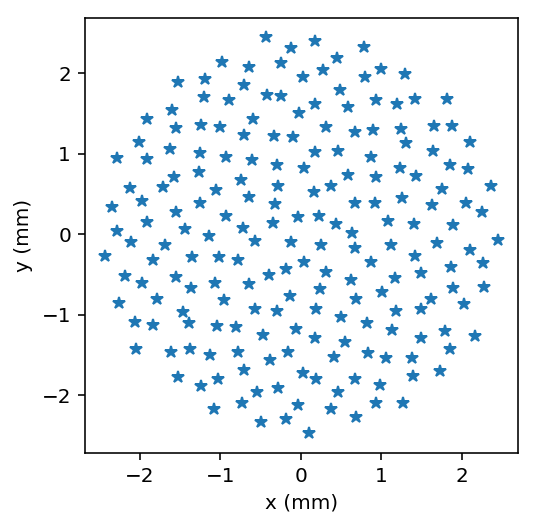

In [22]:
plt.figure()
plt.plot(1000*particles['x'],1000*particles['y'],'*')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlabel('x (mm)')
plt.ylabel('y (mm)')
plt.show()

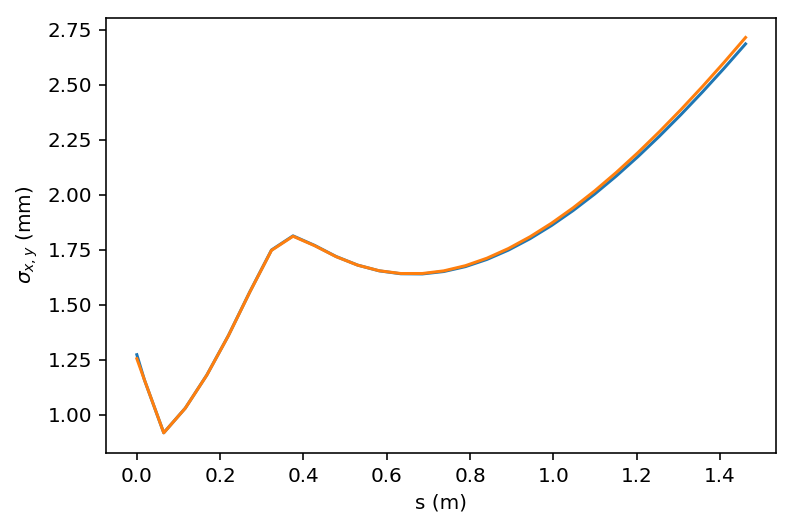

In [23]:
avgz = G.stat('mean_z')
stdx = 1000*G.stat('sigma_x')
stdy = 1000*G.stat('sigma_y')
plt.figure()
plt.plot(avgz,stdx,avgz,stdy)
plt.xlabel('s (m)')
plt.ylabel('$\sigma_{x,y}$ (mm)')
plt.show()

# Using the Evaluate method
The xopt optimization software requires an evaluation function to be run with GPT.  A basic evaluation function is provided by gpt.evaluate:

In [24]:
from gpt.evaluate import evaluate

result = evaluate(settings=settings,
                  simulation='gpt_with_distgen',
                  gpt_input_file=GPT_INPUT_FILE,
                  distgen_input_file=DISTGEN_INPUT_FILE,
                  verbose=False)

In [25]:
result

{'error': False,
 'end_std_x': 0.0017768112399142205,
 'end_std_y': 0.0017848747656373863,
 'end_qbunch': 4.9999999999999995e-11,
 'end_norm_emitt_x': 1.1799872951579944e-06,
 'end_norm_emitt_y': 1.1758424007192168e-06,
 'end_std_t': 9.971742887701527e-12,
 'fingerprint': '8ea4908a9d521b188d666f1f63f6dacf'}